In [2]:
# Just to test the computation of figure 1 in Cooper & Haynes 2011
# Fenwick Cooper, 2022. Fenwick@LittleStick.com.

# Naive implementation in iPython and Matlab vs somewhat optimised C, approximate speed comparison:
#   Time is for all 8 runs and 15 values of h, total 120 computations of the PDF.
#
#   Language    |   Kernel          |   Time        |   Time/120
#   --------------------------------------------------------------
#   iPython     |   Gaussian        |   111m54.6s   |   56.0s
#   Matlab      |   Gaussian        |   33m58.0s    |   17.0s
#   C           |   Gaussian        |   4m19.0s     |   2.2s
#   iPython     |   Epanechnikov    |   27m43.2s    |   13.9s
#   Matlab      |   Epanechnikov    |   27m2.7s*    |   13.5s
#   C           |   Epanechnikov    |   0m33.0s     |   0.3s
#
# * I suspect a problem in this Matlab benchmark.
#
# Computer: 2018 desktop (AMD Ryzen 7 2700X CPU).
#           Python 3.10.4, running in an Jupyter notebook appeared to use only 1 CPU core with this script.
#           Matlab appeared to automatically use all 8 CPU cores with the equivalent script.
#           The C code processed 8 single core jobs in parallel.
#
# Optimisations in the C code not in the iPython or Matlab code:
#       The loop over different h repeats computations. Take code out of that loop.
#       x[i]-x[j] == -(x[j]-x[i]) so ~50% of the calculations are repeated.
#       When i==j expressions are simple, and calculation is unnecessary.
#       The C code processes each model run separately on a core. Trivial parallelisation.
#
# Looking at the trend here we should probably re-write it in FORTRAN 77.
#
# The Gaussian FDT implemented in Matlab completed in ~6ms (6x10^-3 seconds).

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

# Constants
GAUSSIAN_KERNEL = 1
EP_KERNEL = 2

In [16]:
# Define B and Q
B = -0.5
Q = 1

runLength = int(1e6) #65536   # Number of points in time to generate
delta_t = 1         # The time between points (timestep is delta_t/100)
numRuns = 8         # Number of independent runs to do
d = 1               # The number of variables

# Following notation in CH2011
n = runLength   # Inner loop count
m = runLength   # Outer loop count
r = 10          # Upper limit of integral
f = 1.0         # The applied forcing

# Values of h to try
# We want h ranging between ~4e-4 and ~7e-1
numHParams = 15
a = 0.000234647
b = 0.533384
hAll = a * np.exp( b * np.arange(1,numHParams+1) )

# Kernel to use
kernel = GAUSSIAN_KERNEL
# kernel = EP_KERNEL

In [17]:
def fensLinStoch(B, Q, delta_t, run_length):
    # Generates a time series of length run_length of the linear stochastic
    # system
    #  dx/dt = B.x + r where <r.r'>=Q
    # using the Euler-Maruyama method
    #   x_{n+1} = x_n + B*x_n*dt + V*sqrt(D)*randn(len(B))*sqrt(dt)
    # where [V,D]=eig(Q) and dt=delta_t/100. The initial condition is
    # drawn from the appropriate Gaussian distribution to correctly "spin up".
    #
    # x  - The state vector of the system
    # r  - A white noise vector with covariance Q
    # B  - The decay matrix (real part of eigenvalues must all be negative)
    # Q  - The noise covariance matrix (Must be positive definite)
    # dt - The time step used
    #
    # delta_t   - Time between recording data points
    # runLength - Record runLength data points

    save_N_step = 100           # Only save 1/100 time steps
    dt = delta_t / save_N_step  # dt is the timestep used to integrate

    if (type(B) == float):  # Make sure B and Q are numpy arrays
        B = np.array([[B]])
        Q = np.array([[Q]])

    matrix_size = len(B)    # The number of variables in the system

    # Check B
    D = np.real(np.linalg.eig(B)[0])
    if (np.max(D) > 0):
        print('ERROR in fensLinStoch:')
        print('Eigenvalues of B have positive real parts.')
        print('Stochastic system explodes, giving up...')
        x = 0
        return x

    # Check Q
    D = np.linalg.eig(Q)[0]
    if (np.min(D) < 0):
        print('ERROR in fensLinStoch:')
        print('Eigenvalues of Q are negative.')
        print('Random numbers are imaginary, giving up...')
        x = 0
        return x

    # Optimisation variables
    Qd, Qv = np.linalg.eig(Q)
    Q_opt = Qv.dot(np.diag(np.sqrt(Qd))) * np.sqrt(dt)
    B_opt = np.eye(matrix_size) + B * dt

    # Allocate RAM
    x = np.zeros((run_length, matrix_size))

    # Initial condition
    C0 = linalg.solve_continuous_lyapunov(B, -Q)
    D, V = np.linalg.eig(C0)
    x[0,:] = V.dot(np.diag(np.sqrt(D))).dot(np.random.randn(matrix_size))

    # Run the model
    for n in range(run_length-1):
        temp = x[n,:]
        r = Q_opt.dot(np.random.randn(save_N_step,matrix_size).T).T
        for m in range(save_N_step):
            # temp=temp+B*temp*dt+Qv*sqrt(Qd)*randn(matrix_size)*sqrt(dt);
            temp = B_opt.dot(temp.T) + r[m,:]
        
        x[n+1,:] = temp
    
    return x

In [18]:
# Just to get how long it takes to run fensLinStoch
for runNo in range(1):
    x = fensLinStoch(B, Q, delta_t, runLength+r)
    print(x[-1])

[0.39917825]


In [32]:
t= np.arange(0,runLength+r,100)
t

array([    0,   100,   200,   300,   400,   500,   600,   700,   800,
         900,  1000,  1100,  1200,  1300,  1400,  1500,  1600,  1700,
        1800,  1900,  2000,  2100,  2200,  2300,  2400,  2500,  2600,
        2700,  2800,  2900,  3000,  3100,  3200,  3300,  3400,  3500,
        3600,  3700,  3800,  3900,  4000,  4100,  4200,  4300,  4400,
        4500,  4600,  4700,  4800,  4900,  5000,  5100,  5200,  5300,
        5400,  5500,  5600,  5700,  5800,  5900,  6000,  6100,  6200,
        6300,  6400,  6500,  6600,  6700,  6800,  6900,  7000,  7100,
        7200,  7300,  7400,  7500,  7600,  7700,  7800,  7900,  8000,
        8100,  8200,  8300,  8400,  8500,  8600,  8700,  8800,  8900,
        9000,  9100,  9200,  9300,  9400,  9500,  9600,  9700,  9800,
        9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700,
       10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600,
       11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500,
       12600, 12700,

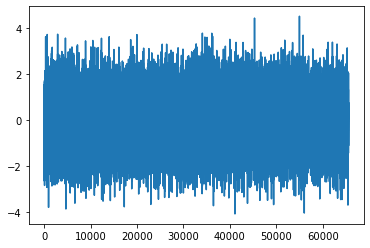

In [28]:
plt.plot(x[:,0])

In [5]:
# The response we are calculating
rpr = np.zeros((r+1, numHParams, numRuns));

for runNo in range(numRuns):

	# Generate an extra r points for computation of the integral without extra programming.
	x = fensLinStoch(B, Q, delta_t, runLength+r)
	
	# For each h parameter we are looking at
	for hNo in range(numHParams):
	
		print('Run ' + str(runNo+1) + '/' + str(numRuns) + ', h param ' + str(hNo+1) + '/' + str(numHParams))
		
		# Choose a value for h
		h = hAll[hNo]
	
		if kernel == GAUSSIAN_KERNEL:
			# Gaussian kernel
			norm1 = -1.0 / (2.0*h**2)
			dRhoORho = np.zeros(runLength)
			# Calculate del rho / rho for each data point
			for j in range(m):
				dx = x[0:n] - x[j]
				N = np.exp(dx**2 * norm1)
				dN = dx * N
				dRhoORho[j] = np.sum(dN) / (h**2 * np.sum(N))
				
		elif (kernel == EP_KERNEL):
			# Epanechnikov kernel
			dRhoORho = np.zeros(runLength)
			for j in range(m):
				dx = x[0:n] - x[j]
				N = h**2 - dx**2
				N *= (N > 0)
				dN = dx * (N > 0)
				dRhoORho[j] = 2.0 * np.sum(dN) / np.sum(N)
		
		# Integrate over all lags
		gamma = np.zeros(r+1)			# Python can't cope with the variable name "lambda"
		for s in range(r+1):
			for j in range(m):
				gamma[s] -= x[j+s] * dRhoORho[j]
		gamma /= runLength
		
		# Finally calculate the response
		rpr[:,hNo,runNo] = f * (np.cumsum(gamma)-gamma[0]/2.0)
		print(rpr[-1])

Run 1/8, h param 1/15
[ 0.51081208  0.5634264   0.56452278 -1.45776055  1.20316085 -0.45996835
 -0.72157957  0.39806698 -0.05386525  0.39071609 -0.41382371]
Run 1/8, h param 2/15


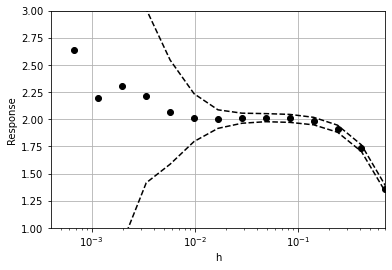

In [5]:
plt.semilogx(hAll, np.mean(rpr[-1,:,:],1).T, 'ko')
plt.semilogx(hAll, np.mean(rpr[-1,:,:],1).T + 2.0 * np.std(rpr[-1,:,:],1), 'k--')
plt.semilogx(hAll, np.mean(rpr[-1,:,:],1).T - 2.0 * np.std(rpr[-1,:,:],1), 'k--')
plt.xlim((np.min(hAll), np.max(hAll)))
plt.ylim((1, 3))
plt.grid(True)
plt.xlabel('h')
plt.ylabel('Response')
plt.show()